## START


In [1]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
BASEMAP_PROVIDERS = {
    "positron": ctx.providers.CartoDB.Positron,
    "dark": ctx.providers.CartoDB.DarkMatter,
    "osm": ctx.providers.OpenStreetMap.Mapnik,
    "satellite": ctx.providers.Esri.WorldImagery,
}

PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa una basemap se contextily è disponibile
    "basemap": "positron"                     # scegli tra: positron, toner, terrain, osm, satellite
}



In [2]:
# === 1. AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === 2. Scarica dati OSM uso del suolo ===
tags = {
    "landuse": True,
    "amenity": True,
    "building": True,
    "leisure": True,
    "natural": True,
    "boundary": True,
}

if hasattr(ox, "features_from_polygon"):
    gdf_mix = ox.features_from_polygon(aoi, tags=tags)
else:
    gdf_mix = ox.geometries_from_polygon(aoi, tags=tags)

# Filtra solo poligoni
gdf_mix = gdf_mix[gdf_mix.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clippa sull'AOI
gdf_mix = gpd.clip(gdf_mix, aoi_gdf)

# === 3. Classificazione uso del suolo (8 categorie: aggiunto verde pubblico/privato) ===
def classifica_landuse(row):
    lu = str(row.get("landuse", "")).lower()
    am = str(row.get("amenity", "")).lower()
    bd = str(row.get("building", "")).lower()
    le = str(row.get("leisure", "")).lower()
    na = str(row.get("natural", "")).lower()
    bdry = str(row.get("boundary", "")).lower()
    access = str(row.get("access", "")).lower()
    operator = str(row.get("operator", "")).lower()

    # --- Verde urbano ---
    # --- Verde urbano ---
    # --- Verde urbano (distinzione più tollerante) ---
    if le in {"park", "garden", "recreation_ground", "nature_reserve"} \
    or lu in {"grass", "meadow", "recreation_ground"} \
    or na in {"wood", "grassland", "heath", "scrub", "wetland"} \
    or bdry == "protected_area":

        # verde pubblico: se access=public o se tipo è park o recreation_ground
        if "public" in access or "municipal" in operator or "comune" in operator \
        or le in {"park", "recreation_ground"}:
            return "Verde pubblico"
        else:
            return "Verde"


    # --- Aree residenziali ---
    if lu == "residential" or bd in {"house", "apartments", "residential"}:
        return "Residenziale"

    # --- Commerciale ---
    if lu in {"commercial", "retail"} or bd in {"retail", "commercial"}:
        return "Commerciale"

    # --- Industriale ---
    if lu == "industrial" or bd == "industrial":
        return "Industriale"

    # --- Istituzionale ---
    if am in {"townhall", "public_building", "library", "courthouse"} or "public" in bd:
        return "Istituzionale"

    # --- Educativo ---
    if am in {"school", "university", "college"}:
        return "Educativo"

    # --- Sanitario ---
    if am in {"hospital", "clinic", "doctors"}:
        return "Sanitario"

    return None

gdf_mix["landuse_class"] = gdf_mix.apply(classifica_landuse, axis=1)
gdf_classified = gdf_mix.dropna(subset=["landuse_class"]).copy()

# === 4. Edifici (building only) ===
building_tags = {"building": True}
if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)

# === 5. Acque: poligoni e linee ===
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua (fiumi, canali)
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)

# Filtro: solo corsi d'acqua visibili
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
else:
    water_line_visible = water_line

water_line3857 = water_line_visible.to_crs(3857)

# === 6. Proiezione uso del suolo e AOI ===
gdf_classified_3857 = gdf_classified.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# === 7. Output statistico ===
print("Geometrie totali:", len(gdf_mix))
print("Geometrie classificate:", len(gdf_classified))
print("Classi individuate:", gdf_classified['landuse_class'].nunique())
print(gdf_classified["landuse_class"].value_counts())


Geometrie totali: 28212
Geometrie classificate: 3399
Classi individuate: 8
landuse_class
Residenziale      1707
Verde             1200
Verde pubblico     176
Commerciale        119
Industriale         78
Educativo           66
Istituzionale       27
Sanitario           26
Name: count, dtype: int64


In [3]:
from shapely.ops import linemerge, unary_union
# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

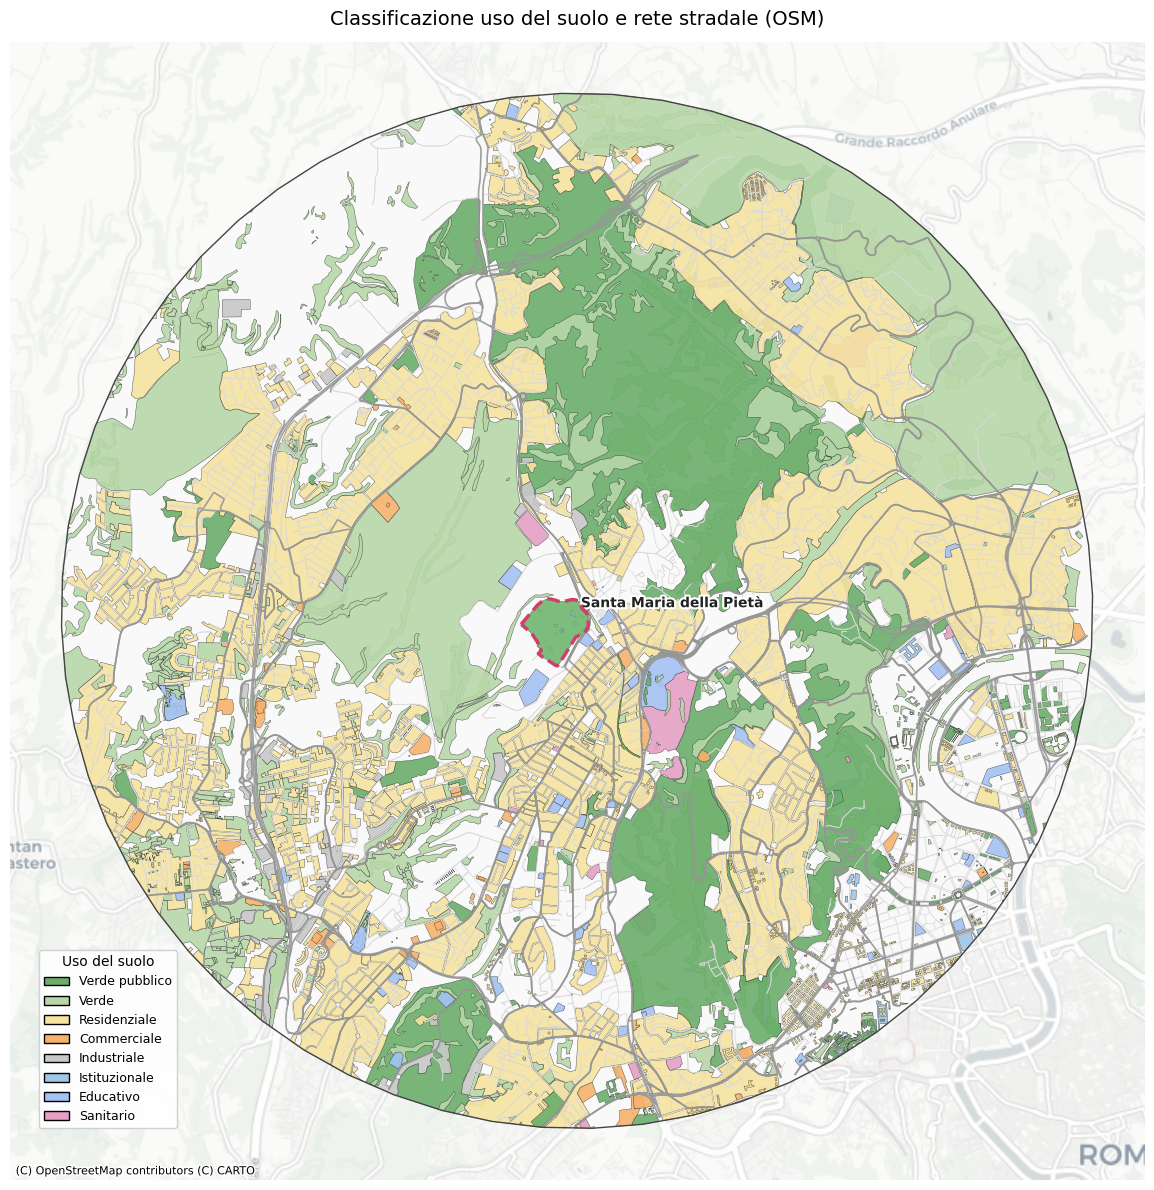

In [ ]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## END